In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime
import os
import datetime
import iisignature as sig
from tqdm import tqdm
from plotly.offline import init_notebook_mode, iplot
from plot_metric.functions import BinaryClassification
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.svm import TimeSeriesSVC
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import joblib


init_notebook_mode(connected=True) ## plotly init
n_splits = 5

In [24]:
# below is unnecessary now

In [25]:
#example try for create train set - this is not used later in the script, this is purely for show
temp_df = pd.read_csv('SMNI_CMI_TRAIN/Train/Data1.csv')
print(temp_df['subject identifier'][0])
print(temp_df["matching condition"][0])
print(np.array(temp_df["sensor value"]).reshape([64,256]))

a
S1 obj
[[ -8.921  -8.433  -2.574 ...   4.262   5.727   8.169]
 [  0.834   3.276   5.717 ...   2.787   9.623  13.041]
 [-19.847 -12.522   1.149 ...   7.009  11.403  12.868]
 ...
 [ -0.478  -0.966  -0.966 ...   4.405   3.916   2.94 ]
 [ -8.901  -7.924  -3.042 ...   4.771   6.236   8.677]
 [ -5.636  -2.706   1.689 ...  15.849  16.337  14.872]]


In [26]:
# initialise scalers
ts_scaler = TimeSeriesScalerMinMax()
scaler = StandardScaler()

In [27]:
#S1: S1 obj - a single object shown;
s1 = 0
#S12: S2 nomatch - object 2 shown in a non matching condition (S1 differed from S2)
s12 = 0
#S21: S2 match - object 2 shown in a matching condition (S1 was identical to S2),
s21 = 0
# initialise numpy arrays to fill with time series
s1_X_train_unscaled = np.zeros((160,256,64))
s1_y_train = np.zeros(160)
s21_X_train_unscaled = np.zeros((159,256,64))
s21_y_train = np.zeros(159)
s12_X_train_unscaled = np.zeros((149,256,64))
s12_y_train = np.zeros(149)

# assign numerical values to the classes
classifier = {'a':1,'c':0}

# run through every file in the train directory and import it, using information from the
# matching condition column to determine which experiment was being conducted.
# using this, put the data into the corresponding numpy array
filenames_list = os.listdir('SMNI_CMI_TRAIN/Train') ## list of file names in the directory
EEG_data = pd.DataFrame({}) ## create an empty df that will hold data from each file
print(len(filenames_list))
for file_name in tqdm(filenames_list):
    temp_df = pd.read_csv('SMNI_CMI_TRAIN/Train/' + file_name) ## read from the file to df
    if temp_df["matching condition"][0] == "S1 obj":
        s1_X_train_unscaled[s1] = np.transpose(np.array(temp_df["sensor value"]).reshape([64,256]))
        s1_y_train[s1] = classifier[temp_df['subject identifier'][0]]
        s1 += 1
    if temp_df["matching condition"][0] == "S2 match":
        s21_X_train_unscaled[s21] = np.transpose(np.array(temp_df["sensor value"]).reshape([64,256]))
        s21_y_train[s21] = classifier[temp_df['subject identifier'][0]]
        s21 += 1
    if temp_df["matching condition"][0] == "S2 nomatch,":
        s12_X_train_unscaled[s12] = np.transpose(np.array(temp_df["sensor value"]).reshape([64,256]))
        s12_y_train[s12] = classifier[temp_df['subject identifier'][0]]
        s12 += 1

s1_X_train = ts_scaler.fit_transform(s1_X_train_unscaled)
s21_X_train = ts_scaler.fit_transform(s21_X_train_unscaled)
s12_X_train = ts_scaler.fit_transform(s12_X_train_unscaled)

print(s1)
print(s21)
print(s12)

468


100%|██████████| 468/468 [00:08<00:00, 53.28it/s]


160
159
149


In [28]:
#t1: S1 obj - a single object shown;
t1 = 0
#t12: S2 nomatch - object 2 shown in a non matching condition (S1 differed from S2)
t12 = 0
#t21: S2 match - object 2 shown in a matching condition (S1 was identical to S2),
t21 = 0
t1_X_test_unscaled = np.zeros((160,256,64))
t1_y_test = np.zeros(160)
t21_X_test_unscaled = np.zeros((160,256,64))
t21_y_test = np.zeros(160)
t12_X_test_unscaled = np.zeros((160,256,64))
t12_y_test = np.zeros(160)

# same as above but for test data
classifier = {'a':1,'c':0}

filenames_list = os.listdir('SMNI_CMI_TEST') ## list of file names in the directory
EEG_data = pd.DataFrame({}) ## create an empty df that will hold data from each file
print(len(filenames_list))
for file_name in tqdm(filenames_list):
    if file_name == "Test":
        pass
    else:
        temp_df = pd.read_csv('SMNI_CMI_TEST/' + file_name) ## read from the file to df
        if temp_df["matching condition"][0] == "S1 obj":
            t1_X_test_unscaled[t1] = np.transpose(np.array(temp_df["sensor value"]).reshape([64,256]))
            t1_y_test[t1] = classifier[temp_df['subject identifier'][0]]
            t1 += 1
        if temp_df["matching condition"][0] == "S2 match":
            t21_X_test_unscaled[t21] = np.transpose(np.array(temp_df["sensor value"]).reshape([64,256]))
            t21_y_test[t21] = classifier[temp_df['subject identifier'][0]]
            t21 += 1
        if temp_df["matching condition"][0] == "S2 nomatch,":
            t12_X_test_unscaled[t12] = np.transpose(np.array(temp_df["sensor value"]).reshape([64,256]))
            t12_y_test[t12] = classifier[temp_df['subject identifier'][0]]
            t12 += 1

t1_X_test = ts_scaler.fit_transform(t1_X_test_unscaled)
t21_X_test = ts_scaler.fit_transform(t21_X_test_unscaled)
t12_X_test = ts_scaler.fit_transform(t12_X_test_unscaled)

print(t1)
print(t21)
print(t12)

481


100%|██████████| 481/481 [00:09<00:00, 52.45it/s]


160
160
160


Each of these models are trained using a grid search seen in the raw cell above the code cell. This determines the model in advance and saves it into a pickle file, so that it can be tested faster when running the notebook. The pickle file is then read to return the model, then the model is tested.

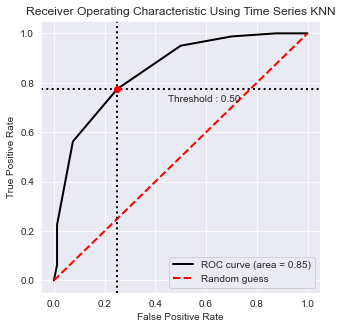

accuracy is 0.7625
auc is 0.8503125
f1-measure 0.7654320987654322
[0.63671875 0.66015625 0.83789062 0.63671875 0.53515625] mean CV on Train = 0.661328125
0:03:55.727307


In [29]:
start = datetime.datetime.now()

# reload the model from a pickle
loaded_model = joblib.load(open('ts_knn_1.pkl', 'rb'))
# predict y and its probabilities
y_pred_proba = loaded_model.predict_proba(t1_X_test)[:,1]
y_pred = loaded_model.predict(t1_X_test)
# determine cross vlaidation score on the training set for each fold
cv_score = cross_val_score(loaded_model, s1_X_train, s1_y_train, scoring='roc_auc', n_jobs=-1)
# initialise the ROC graphing
bc = BinaryClassification(t1_y_test, y_pred_proba, labels=["Class 0", "Class 1"])
# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.title("Receiver Operating Characteristic Using Time Series KNN")
plt.show()

# print scores and time taken to recall
score = roc_auc_score(t1_y_test, y_pred_proba)
accuracy = accuracy_score(t1_y_test, y_pred)
roc_auc = roc_auc_score(t1_y_test, y_pred_proba)
f1 = f1_score(t1_y_test, y_pred)
end = datetime.datetime.now()
print("accuracy is " + str(accuracy))
print("auc is " + str(roc_auc))
print("f1-measure " + str(f1))
print(cv_score, "mean CV on Train = " + str(cv_score.mean()))
print(end-start)

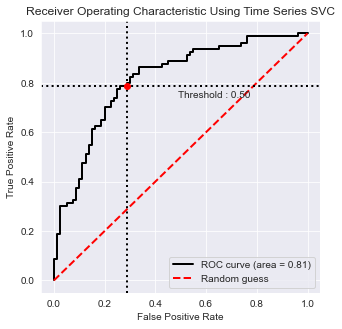

accuracy is 0.75
auc is 0.8124999999999999
f1-measure 0.7590361445783131
[0.4140625  0.74609375 0.82421875 0.68359375 0.43359375] mean CV on Train = 0.6203125
0:00:07.208216


In [30]:
start = datetime.datetime.now()

loaded_model = joblib.load(open('ts_svc_1.pkl', 'rb'))
y_pred_proba = loaded_model.predict_proba(t1_X_test)[:,1]
y_pred = loaded_model.predict(t1_X_test)
cv_score = cross_val_score(loaded_model, s1_X_train, s1_y_train, scoring='roc_auc', n_jobs=-1)
bc = BinaryClassification(t1_y_test, y_pred_proba, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.title("Receiver Operating Characteristic Using Time Series SVC")
plt.show()
score = roc_auc_score(t1_y_test, y_pred_proba)

score = roc_auc_score(t1_y_test, y_pred_proba)
accuracy = accuracy_score(t1_y_test, y_pred)
roc_auc = roc_auc_score(t1_y_test, y_pred_proba)
f1 = f1_score(t1_y_test, y_pred)
end = datetime.datetime.now()
print("accuracy is " + str(accuracy))
print("auc is " + str(roc_auc))
print("f1-measure " + str(f1))
print(cv_score, "mean CV on Train = " + str(cv_score.mean()))
print(end-start)

In [31]:
s1_sig_train_unscaled = sig.sig(s1_X_train, 2)
s1_sig_test_unscaled = sig.sig(t1_X_test, 2)
s1_sig_train = scaler.fit_transform(s1_sig_train_unscaled)
s1_sig_test = scaler.fit_transform(s1_sig_test_unscaled)

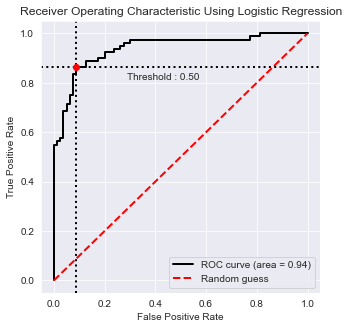

accuracy is 0.88125
auc is 0.939375
f1-measure 0.8774193548387097
[0.9453125  0.6015625  0.87890625 0.52734375 0.4921875 ] mean CV on Train = 0.6890625
0:00:01.928293


In [32]:
start = datetime.datetime.now()

loaded_model = joblib.load(open('lr_1.pkl', 'rb'))
y_pred_proba = loaded_model.predict_proba(s1_sig_test)[:, 1]
y_pred = loaded_model.predict(s1_sig_test)
cv_score = cross_val_score(loaded_model, s1_sig_train, s1_y_train, scoring='roc_auc', n_jobs=-1)
bc = BinaryClassification(t1_y_test, y_pred_proba, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.title("Receiver Operating Characteristic Using Logistic Regression")
plt.show()
score = roc_auc_score(t1_y_test, y_pred_proba)
accuracy = accuracy_score(t1_y_test, y_pred)
roc_auc = roc_auc_score(t1_y_test, y_pred_proba)
f1 = f1_score(t1_y_test, y_pred)
end = datetime.datetime.now()
print("accuracy is " + str(accuracy))
print("auc is " + str(roc_auc))
print("f1-measure " + str(f1))
print(cv_score, "mean CV on Train = " + str(cv_score.mean()))
print(end-start)

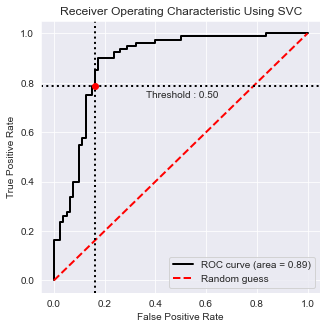

accuracy is 0.8125
auc is 0.88515625
f1-measure 0.8076923076923076
[0.99609375 0.703125   1.         0.6484375  0.32421875] mean CV on Train = 0.734375
0:00:01.348583


In [33]:
start = datetime.datetime.now()


loaded_model = joblib.load(open('svc_1.pkl', 'rb'))
y_pred_proba = loaded_model.predict_proba(s1_sig_test)[:, 1]
y_pred = loaded_model.predict(s1_sig_test)
cv_score = cross_val_score(loaded_model, s1_sig_train, s1_y_train, scoring='roc_auc', n_jobs=-1)
bc = BinaryClassification(t1_y_test, y_pred_proba, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.title("Receiver Operating Characteristic Using SVC")
plt.show()
score = roc_auc_score(t1_y_test, y_pred_proba)
accuracy = accuracy_score(t1_y_test, y_pred)
roc_auc = roc_auc_score(t1_y_test, y_pred_proba)
f1 = f1_score(t1_y_test, y_pred)
end = datetime.datetime.now()
print("accuracy is " + str(accuracy))
print("auc is " + str(roc_auc))
print("f1-measure " + str(f1))
print(cv_score, "mean CV on Train = " + str(cv_score.mean()))
print(end-start)

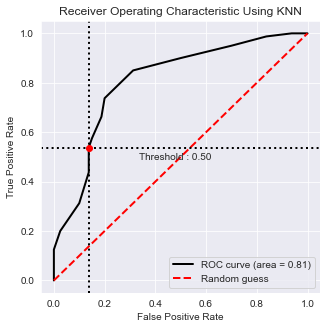

accuracy is 0.7
auc is 0.8096875
f1-measure 0.6417910447761194
[0.93164062 0.66796875 0.95898438 0.48828125 0.35351562] mean CV on Train = 0.680078125
0:00:00.568735


In [34]:
start = datetime.datetime.now()


loaded_model = joblib.load(open('knn_1.pkl', 'rb'))
y_pred_proba = loaded_model.predict_proba(s1_sig_test)[:, 1]
y_pred = loaded_model.predict(s1_sig_test)
cv_score = cross_val_score(loaded_model, s1_sig_train, s1_y_train, scoring='roc_auc', n_jobs=-1)
bc = BinaryClassification(t1_y_test, y_pred_proba, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.title("Receiver Operating Characteristic Using KNN")
plt.show()
score = roc_auc_score(t1_y_test, y_pred_proba)

score = roc_auc_score(t1_y_test, y_pred_proba)
accuracy = accuracy_score(t1_y_test, y_pred)
roc_auc = roc_auc_score(t1_y_test, y_pred_proba)
f1 = f1_score(t1_y_test, y_pred)
end = datetime.datetime.now()
print("accuracy is " + str(accuracy))
print("auc is " + str(roc_auc))
print("f1-measure " + str(f1))
print(cv_score, "mean CV on Train = " + str(cv_score.mean()))
print(end-start)

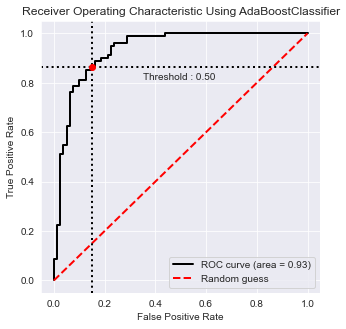

accuracy is 0.85
auc is 0.9332812500000001
f1-measure 0.85
[0.9765625  0.671875   0.8671875  0.59765625 0.4375    ] mean CV on Train = 0.71015625
0:00:12.186569


In [35]:
start = datetime.datetime.now()


loaded_model = joblib.load(open('ada_1.pkl', 'rb'))
y_pred_proba = loaded_model.predict_proba(s1_sig_test)[:, 1]
y_pred = loaded_model.predict(s1_sig_test)
cv_score = cross_val_score(loaded_model, s1_sig_train, s1_y_train, scoring='roc_auc', n_jobs=-1)
bc = BinaryClassification(t1_y_test, y_pred_proba, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.title("Receiver Operating Characteristic Using AdaBoostClassifier")
plt.show()
score = roc_auc_score(t1_y_test, y_pred_proba)

score = roc_auc_score(t1_y_test, y_pred_proba)
accuracy = accuracy_score(t1_y_test, y_pred)
roc_auc = roc_auc_score(t1_y_test, y_pred_proba)
f1 = f1_score(t1_y_test, y_pred)
end = datetime.datetime.now()
print("accuracy is " + str(accuracy))
print("auc is " + str(roc_auc))
print("f1-measure " + str(f1))
print(cv_score, "mean CV on Train = " + str(cv_score.mean()))
print(end-start)

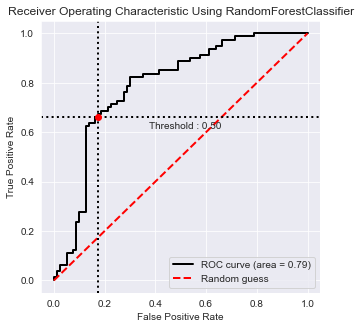

accuracy is 0.74375
auc is 0.7903125
f1-measure 0.7210884353741497
[1.         0.890625   1.         0.53125    0.38671875] mean CV on Train = 0.76171875
0:00:02.378547


In [36]:
start = datetime.datetime.now()


loaded_model = joblib.load(open('rf_1.pkl', 'rb'))
y_pred_proba = loaded_model.predict_proba(s1_sig_test)[:, 1]
y_pred = loaded_model.predict(s1_sig_test)
cv_score = cross_val_score(loaded_model, s1_sig_train, s1_y_train, scoring='roc_auc', n_jobs=-1)
bc = BinaryClassification(t1_y_test, y_pred_proba, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.title("Receiver Operating Characteristic Using RandomForestClassifier")
plt.show()
score = roc_auc_score(t1_y_test, y_pred_proba)
score = roc_auc_score(t1_y_test, y_pred_proba)
accuracy = accuracy_score(t1_y_test, y_pred)
roc_auc = roc_auc_score(t1_y_test, y_pred_proba)
f1 = f1_score(t1_y_test, y_pred)
end = datetime.datetime.now()
print("accuracy is " + str(accuracy))
print("auc is " + str(roc_auc))
print("f1-measure " + str(f1))
print(cv_score, "mean CV on Train = " + str(cv_score.mean()))
print(end-start)